In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --target=$my_path statsmodels==0.11.1
!pip install --target=$my_path fbprophet

In [ ]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

## 데이터 불러오기

### 1) read_csv

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Bitcoin_Trading/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

### 2) numpy array로 변환하기

In [ ]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [ ]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)
test_x_array (535, 1380, 10)



### 3) 샘플 확인하기

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

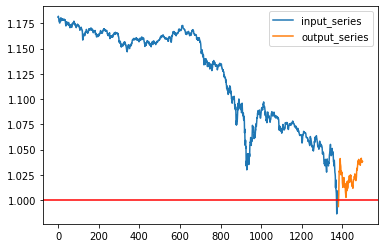

In [ ]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

## pbrophet으로 모델 훈련하기
1) train 샘플 훈련하기

In [ ]:
start_time='2021-01-31 00:00:00'
start_dt=datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [ ]:
idx = 1121
data_col_idx = 1 # 1 open, 2 high
x_series = train_x_array[idx,:,data_col_idx]
y_series = train_y_array[idx,:,data_col_idx]

model = ARIMA(x_series, order=(3,0,1))
fit  = model.fit()
preds1 = fit.predict(1381,1380+120, typ='levels')

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=True,
                  changepoint_prior_scale=0.06)
prophet.fit(x_df)

future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

pred_y = forecast_data.yhat.values[-120:]


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


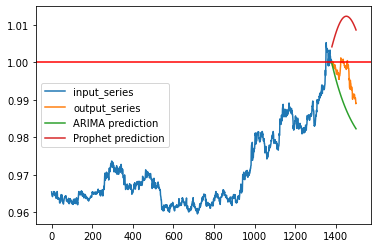

In [ ]:
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds1, label = 'ARIMA prediction')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'Prophet prediction')
plt.legend()
plt.show()

## Train data 학습하고 추론하기

In [ ]:
train_pred_array = np.zeros([train_x_array.shape[0],
                           120])
for idx in tqdm(range(train_x_array.shape[0])):
    try:
        x_series = train_x_array[idx,:,data_col_idx]
        fit = None
        try:
          model = ARIMA(x_series, order=(3,0,1))
          fit  = model.fit()
        except Exception as e:
          model = ARIMA(x_series, order=(4,0,1))
          fit  = model.fit()
          
        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False, daily_seasonality=True,
                          changepoint_prior_scale=0.06)
        prophet.fit(x_df)

        preds = fit.predict(1381,1380+120, typ='levels')

        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        max_two_model = np.maximum(pred_y, preds)

        train_pred_array[idx,:] = max_two_model
    except Exception as e:
        print(repr(e))
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

  3%|▎         | 234/7661 [00:00<00:03, 2337.84it/s]

NameError("name 'data_col_idx' is not defined")
0  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
8  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
9  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
10  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
11  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
12  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
13  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
14  샘플은 수렴하지 않습니다.
NameE

  6%|▌         | 468/7661 [00:00<00:03, 1813.08it/s]

 샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
305  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
306  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
307  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
308  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
309  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
310  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
311  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
312  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
313  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
314  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
315  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
316  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
317  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
318  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' i

 10%|█         | 803/7661 [00:00<00:05, 1169.09it/s]


637  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
638  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
639  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
640  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
641  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
642  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
643  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
644  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
645  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
646  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
647  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
648  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
649  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
650  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
651  샘플은 수렴하지 않습니다.
NameError("name 'data_col_i

 14%|█▍        | 1103/7661 [00:00<00:05, 1151.78it/s]

NameError("name 'data_col_idx' is not defined")
969  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
970  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
971  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
972  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
973  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
974  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
975  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
976  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
977  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
978  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
979  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
980  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
981  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
982  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")


 17%|█▋        | 1339/7661 [00:01<00:06, 1024.66it/s]


1134  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1135  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1136  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1137  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1138  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1139  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1140  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1141  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1142  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1143  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1144  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1145  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1146  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1147  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1148  샘플은 수렴하지 않습니다.
NameError("n

 21%|██▏       | 1632/7661 [00:01<00:05, 1044.56it/s]

NameError("name 'data_col_idx' is not defined")
1466  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1467  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1468  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1469  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1470  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1471  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1472  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1473  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1474  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1475  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1476  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1477  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1478  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1479  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 23%|██▎       | 1798/7661 [00:01<00:05, 1057.33it/s]


NameError("name 'data_col_idx' is not defined")
1763  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1764  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1765  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1766  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1767  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1768  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1769  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1770  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1771  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1772  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1773  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1774  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1775  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1776  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is

 28%|██▊       | 2130/7661 [00:01<00:04, 1161.92it/s]

 샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1964  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1965  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1966  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1967  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1968  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1969  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1970  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1971  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1972  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1973  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1974  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1975  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1976  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
1977  샘플은 수렴하지 않습니다.
NameError("name 'd

 32%|███▏      | 2462/7661 [00:02<00:04, 1280.34it/s]

  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2296  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2297  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2298  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2299  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2300  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2301  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2302  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2303  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2304  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2305  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2306  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2307  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2308  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2309  샘플은 수렴하지 않습니다.
NameError("name '

 34%|███▍      | 2628/7661 [00:02<00:04, 1184.45it/s]

NameError("name 'data_col_idx' is not defined")
2583  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2584  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2585  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2586  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2587  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2588  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2589  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2590  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2591  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2592  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2593  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2594  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2595  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2596  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 39%|███▊      | 2959/7661 [00:02<00:04, 1172.47it/s]


2793  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2794  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2795  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2796  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2797  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2798  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2799  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2800  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2801  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2802  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2803  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2804  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2805  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2806  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
2807  샘플은 수렴하지 않습니다.
NameError("n

 43%|████▎     | 3291/7661 [00:02<00:03, 1220.57it/s]

NameError("name 'data_col_idx' is not defined")
3125  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3126  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3127  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3128  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3129  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3130  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3131  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3132  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3133  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3134  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3135  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3136  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3137  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3138  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 45%|████▌     | 3457/7661 [00:02<00:03, 1166.16it/s]


3440  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3441  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3442  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3443  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3444  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3445  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3446  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3447  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3448  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3449  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3450  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3451  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3452  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3453  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3454  샘플은 수렴하지 않습니다.
NameError("n

 49%|████▉     | 3789/7661 [00:03<00:03, 1192.60it/s]

 샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3623  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3624  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3625  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3626  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3627  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3628  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3629  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3630  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3631  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3632  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3633  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3634  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3635  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3636  샘플은 수렴하지 않습니다.
NameError("name 'd

 52%|█████▏    | 3955/7661 [00:03<00:03, 1114.18it/s]

NameError("name 'data_col_idx' is not defined")
3909  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3910  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3911  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3912  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3913  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3914  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3915  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3916  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3917  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3918  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3919  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3920  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3921  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
3922  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 57%|█████▋    | 4350/7661 [00:03<00:02, 1365.25it/s]

4120  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4121  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4122  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4123  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4124  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4125  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4126  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4127  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4128  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4129  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4130  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4131  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4132  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4133  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4134  샘플은 수렴하지 않습니다.
NameError("na

 60%|██████    | 4630/7661 [00:03<00:02, 1223.26it/s]


4452  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4453  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4454  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4455  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4456  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4457  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4458  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4459  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4460  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4461  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4462  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4463  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4464  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4465  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4466  샘플은 수렴하지 않습니다.
NameError("n

 64%|██████▍   | 4900/7661 [00:04<00:02, 1205.65it/s]

NameError("name 'data_col_idx' is not defined")
4693  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4694  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4695  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4696  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4697  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4698  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4699  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4700  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4701  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4702  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4703  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4704  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4705  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4706  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 67%|██████▋   | 5134/7661 [00:04<00:02, 1103.85it/s]


4949  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4950  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4951  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4952  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4953  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4954  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4955  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4956  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4957  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4958  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4959  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4960  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4961  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4962  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
4963  샘플은 수렴하지 않습니다.
NameError("n

 71%|███████   | 5447/7661 [00:04<00:01, 1195.01it/s]

NameError("name 'data_col_idx' is not defined")
5281  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5282  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5283  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5284  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5285  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5286  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5287  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5288  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5289  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5290  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5291  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5292  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5293  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5294  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 75%|███████▍  | 5739/7661 [00:04<00:01, 1089.42it/s]


NameError("name 'data_col_idx' is not defined")
5606  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5607  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5608  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5609  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5610  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5611  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5612  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5613  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5614  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5615  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5616  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5617  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5618  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5619  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is

 78%|███████▊  | 5961/7661 [00:05<00:01, 941.86it/s] 

NameError("name 'data_col_idx' is not defined")
5778  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5779  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5780  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5781  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5782  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5783  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5784  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5785  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5786  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5787  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5788  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5789  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5790  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
5791  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is 

 80%|███████▉  | 6110/7661 [00:05<00:01, 1051.59it/s]

6086  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6087  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6088  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6089  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6090  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6091  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6092  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6093  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6094  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6095  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6096  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6097  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6098  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6099  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6100  샘플은 수렴하지 않습니다.
NameError("na

 84%|████████▍ | 6442/7661 [00:05<00:01, 1155.88it/s]

 샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6276  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6277  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6278  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6279  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6280  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6281  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6282  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6283  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6284  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6285  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6286  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6287  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6288  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6289  샘플은 수렴하지 않습니다.
NameError("name 'd

 88%|████████▊ | 6755/7661 [00:05<00:00, 1209.56it/s]

  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6608  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6609  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6610  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6611  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6612  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6613  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6614  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6615  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6616  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6617  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6618  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6619  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6620  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6621  샘플은 수렴하지 않습니다.
NameError("name '

 94%|█████████▍| 7183/7661 [00:06<00:00, 1320.96it/s]


6851  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6852  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6853  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6854  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6855  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6856  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6857  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6858  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6859  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6860  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6861  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6862  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6863  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6864  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
6865  샘플은 수렴하지 않습니다.
NameError("n

 97%|█████████▋| 7446/7661 [00:06<00:00, 1161.97it/s]

  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7271  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7272  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7273  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7274  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7275  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7276  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7277  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7278  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7279  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7280  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7281  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7282  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7283  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7284  샘플은 수렴하지 않습니다.
NameError("name '

100%|██████████| 7661/7661 [00:06<00:00, 1179.08it/s]

7602  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7603  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7604  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7605  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7606  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7607  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7608  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7609  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7610  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7611  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7612  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7613  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7614  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7615  샘플은 수렴하지 않습니다.
NameError("name 'data_col_idx' is not defined")
7616  샘플은 수렴하지 않습니다.
NameError("na

In [ ]:
train_pred_df=pd.DataFrame(train_pred_array)
train_pred_df["sample_id"]=list(range(len(train_pred_df)))
train_pred_df.to_csv("/content/drive/My Drive/Colab Notebooks/Bitcoin_Trading/train_pred_arima_prophet_1_trial.csv")

## Test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,data_col_idx]
        fit = None
        try:
          model = ARIMA(x_series, order=(3,0,1))
          fit  = model.fit()
        except Exception as e:
          model = ARIMA(x_series, order=(4,0,1))
          fit  = model.fit()
          
        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False, daily_seasonality=True,
                          changepoint_prior_scale=0.06)
        prophet.fit(x_df)

        preds = fit.predict(1381,1380+120, typ='levels')

        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        max_two_model = np.maximum(pred_y, preds)

        
    except Exception as e:
        print(repr(e))
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 535/535 [1:02:26<00:00,  7.00s/it]


In [ ]:
test_pred_df=pd.DataFrame(test_pred_array)
test_pred_df["sample_id"]=list(range(len(test_pred_df)))
test_pred_df.to_csv("/content/drive/My Drive/Colab Notebooks/Bitcoin_Trading/test_pred_arima_prophet_1_trial.csv")

## array_to_submission : 투자 후 금액 계산하기

In [ ]:
def array_to_submission(pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    arr1 = (buy_price > 1.05) * 1
    submission.loc[:, 'buy_quantity'] = arr1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)

    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
submission = array_to_submission(test_pred_array)

In [ ]:
submission.buy_quantity.value_counts() 

0    348
1    187
Name: buy_quantity, dtype: int64

In [ ]:
submission.sample_id = submission.sample_id + test_x_df.sample_id.min()

In [ ]:
submission.to_csv(data_path+"/submission_pred_arima_prophet_1_trial.csv", index = False)